In [40]:
# Importing the libraries
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm # Progress bar for long loops
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

In [2]:
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

# 1. Data reading and preprocessing

In [3]:
# Find all the files in the bbc folder
all_data = glob.glob("./datasets_coursework1/bbc/*/*.txt")

# Make pandas dataframe
dataset = []
for document in all_data:
    with open(document, 'r') as fp:
        text = fp.read()
    label = document.split('/')[3]
    dataset.append(dict(text=text, label=label))
df = pd.DataFrame(dataset)
df.label.value_counts()

label
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [4]:
# Define the text preprocessing function
def preprocess_text(text):
    # Text tokenization using nltk
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    # Remove non-alphabetic characters
    tokens = [word for word in tokens if word.isalpha()]
    # Remove words with length <= 2
    tokens = [word for word in tokens if len(word) > 2]
    # Remove stopwords
    tokens = [word for word in tokens if word not in english_stopwords]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    return text
    
# Apply the text preprocessing function to the text column
df['text'] = [preprocess_text(text) for text in tqdm(df['text'])]

100%|██████████| 2225/2225 [00:05<00:00, 416.05it/s]


In [5]:
# Apply sklearn's train_test_split function to split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print("Training set size:", df_train.shape[0])
print("Testing set size:", df_test.shape[0])

Training set size: 1780
Testing set size: 445


# 2. Text vectorization

In [12]:
# Define the function to extract n-grams from the text
NGRAM = (1, 2) # Unigrams and bigrams

In [6]:
# An utility function to get list of n-gram tokens from a text document
def get_ngram_tokens(tokens, ngram=NGRAM):
    ngram_tokens = []
    for i in range(ngram[0], ngram[1]+1):
        ngram_tokens += list(ngrams(tokens, i))
    ngram_tokens = [' '.join(token) for token in ngram_tokens]
    return ngram_tokens

# Test
print(get_ngram_tokens(['this', 'is', 'a', 'test', 'document'], ngram=(1, 2)))

['this', 'is', 'a', 'test', 'document', 'this is', 'is a', 'a test', 'test document']


In [7]:
# Term frequencies
def build_vocabulary(documents, ngram=NGRAM):
    vocabulary = {}
    for document in documents:
        ngram_tokens = get_ngram_tokens(document.split(), ngram)
        for token in ngram_tokens:
            if token not in vocabulary:
                vocabulary[token] = 1
            else:
                vocabulary[token] += 1
    return vocabulary

vocab = build_vocabulary(df_train['text'])
# Remove terms that appear in less than 5 documents
vocab = {k: v for k, v in vocab.items() if v >= 5}
# Remove terms that appear in more than 50% of the documents
vocab = {k: v for k, v in vocab.items() if v / df_train.shape[0] <= 0.5}

# Print final vocabulary size
print("Vocabulary size:", len(vocab))

Vocabulary size: 13497


In [9]:
# Vectorize the text using the vocabulary
def build_text_vector(vocab, documents, ngram=NGRAM):
    vec = np.zeros((len(documents), len(vocab)))
    for i, document in enumerate(documents):
        ngram_tokens = get_ngram_tokens(document.split(), ngram)
        for token in ngram_tokens:
            if token in vocab:
                vec[i, list(vocab.keys()).index(token)] = 1
    return vec

train_tf = build_text_vector(vocab, tqdm(df_train['text'], desc="Vectorizing training set"))
test_tf = build_text_vector(vocab, tqdm(df_test['text'], desc="Vectorizing testing set"))

Vectorizing testing set: 100%|██████████| 445/445 [00:09<00:00, 45.97it/s]


In [10]:
print("Training set shape:", train_tf.shape)
print("Testing set shape:", test_tf.shape)

Training set shape: (1780, 13497)
Testing set shape: (445, 13497)


# 3. Select other features

### 3.1 Text Lengths

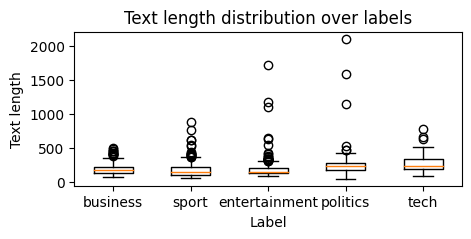

In [23]:
# Boxplot the text lengths over labels
text_lengths = df_train['text'].apply(lambda x: len(x.split()))
text_lengths_df = pd.DataFrame(dict(text_length=text_lengths, label=df_train['label']))
plt.figure(figsize=(5, 2))
plt.title("Text length distribution over labels")
plt.xlabel("Label")
plt.ylabel("Text length")
plt.boxplot([text_lengths_df[text_lengths_df['label'] == label]['text_length'] for label in text_lengths_df['label'].unique()], labels=text_lengths_df['label'].unique())
plt.show()

### 3.2 Average token lengths

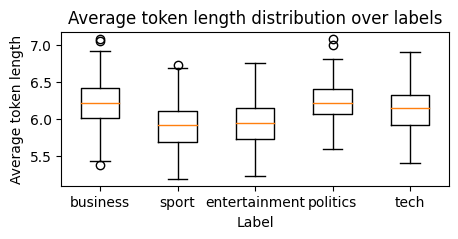

In [24]:
# Boxplot the average token length over labels
avg_token_lengths = df_train['text'].apply(lambda x: np.mean([len(token) for token in x.split()]))
avg_token_lengths_df = pd.DataFrame(dict(avg_token_length=avg_token_lengths, label=df_train['label']))
plt.figure(figsize=(5, 2))
plt.title("Average token length distribution over labels")
plt.xlabel("Label")
plt.ylabel("Average token length")
plt.boxplot([avg_token_lengths_df[avg_token_lengths_df['label'] == label]['avg_token_length'] for label in avg_token_lengths_df['label'].unique()], labels=avg_token_lengths_df['label'].unique())
plt.show()

# 3. Hyperparameter Tuning

In [26]:
# Concatenate into feature vector
train_features = np.concatenate([train_tf, 
                                 text_lengths_df['text_length'].values.reshape(-1, 1), 
                                 avg_token_lengths_df['avg_token_length'].values.reshape(-1, 1)], axis=1)
test_features = np.concatenate([test_tf, 
                                df_test['text'].apply(lambda x: len(x.split())).values.reshape(-1, 1), 
                                df_test['text'].apply(lambda x: np.mean([len(token) for token in x.split()])).values.reshape(-1, 1)], axis=1)
print("Training set shape:", train_features.shape)
print("Testing set shape:", test_features.shape)

Training set shape: (1780, 13499)
Testing set shape: (445, 13499)


In [46]:
params_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, max_depth=None),
                           params_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(train_features, df_train['label'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ................min_samples_leaf=1, n_estimators=10; total time=   1.3s
[CV] END ................min_samples_leaf=1, n_estimators=10; total time=   1.6s
[CV] END ................min_samples_leaf=1, n_estimators=10; total time=   1.6s
[CV] END ................min_samples_leaf=1, n_estimators=10; total time=   1.7s
[CV] END ................min_samples_leaf=1, n_estimators=10; total time=   1.7s
[CV] END ................min_samples_leaf=1, n_estimators=50; total time=   4.9s
[CV] END ................min_samples_leaf=1, n_estimators=50; total time=   5.1s
[CV] END ................min_samples_leaf=1, n_estimators=50; total time=   5.1s
[CV] END ................min_samples_leaf=1, n_estimators=50; total time=   5.2s
[CV] END ................min_samples_leaf=1, n_estimators=50; total time=   5.3s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   9.6s
[CV] END ...............min_samples_leaf=1, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 4, 8, 16],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500,
                                          600]},
             verbose=2)

In [49]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'min_samples_leaf': 1, 'n_estimators': 300}
Best cross-validation score: 0.9623595505617978


In [52]:
# Train the model
clf = grid_search.best_estimator_
print("Training accuracy:", clf.score(train_features, df_train['label']))
pred = clf.predict(test_features)
print("Testing accuracy:", clf.score(test_features, df_test['label']))
print(metrics.classification_report(df_test['label'], pred))

Training accuracy: 1.0
Testing accuracy: 0.9685393258426966
               precision    recall  f1-score   support

     business       0.95      0.98      0.97       102
entertainment       1.00      0.96      0.98        77
     politics       0.96      0.92      0.94        84
        sport       0.98      1.00      0.99       102
         tech       0.95      0.97      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



In [53]:
report = metrics.classification_report(df_test['label'], pred, output_dict=True)
# to markdown
report_df = pd.DataFrame(report).transpose()
print(report_df.to_markdown())

|               |   precision |   recall |   f1-score |    support |
|:--------------|------------:|---------:|-----------:|-----------:|
| business      |    0.952381 | 0.980392 |   0.966184 | 102        |
| entertainment |    1        | 0.961039 |   0.980132 |  77        |
| politics      |    0.9625   | 0.916667 |   0.939024 |  84        |
| sport         |    0.980769 | 1        |   0.990291 | 102        |
| tech          |    0.95122  | 0.975    |   0.962963 |  80        |
| accuracy      |    0.968539 | 0.968539 |   0.968539 |   0.968539 |
| macro avg     |    0.969374 | 0.96662  |   0.967719 | 445        |
| weighted avg  |    0.968829 | 0.968539 |   0.968417 | 445        |


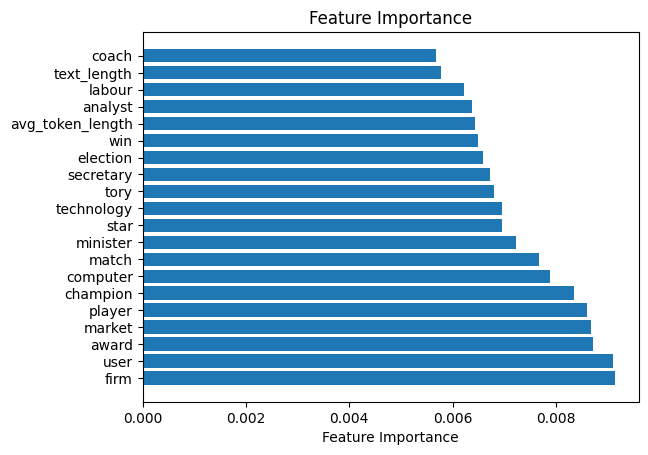

In [56]:
# Feature importance
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:20]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(vocab.keys()) + ['text_length', 'avg_token_length'])[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()